# Project 3 - FYS-STK4155
## Weather classification using a PyTorch neural network and our own built feed forward network

This notebook contains the code which produces the results for the Project 3 report in FYS-STK4155 regarding PyTorch application on building a Neural Network which handles weather type classification.

The dataset used was retrieved from: https://www.kaggle.com/datasets/nikhil7280/weather-type-classification/data, 17.11.25.

*Fall 2025*

**Authors:** Martine Jenssen Pedersen, Sverre Manu Johansen & Kjersti Stangeland

### Comparing a PyTorch neural network with out own FFNN

**We will do numerical experiments and check model performances based on***
* Model architectures (# layers, # nodes)
* Activation functions
    * relu
    * lrelu
    * sigmoid
* Learning rates
* Number of epochs
* Regularization

**In this notebook will use**
* Adam optimizer because we found that was best in Project 2.
* Our own built FFNN from Project 2.
* A NN built with PyTorch.
* Accuracy score to determine how well the networks do classification, using CrossEntropy and Softmax.
* Visualize results using heatmaps.

**In other notebooks you'll find**
* Similar experiments done with our own built logistic regression model using Scikitlearn, our own FFNN with one layer, and our PyTorch NN with one layer.

In [1]:
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from functions.make_dataset import *
from functions.nn_pytorch import *
from functions.ffnn import *
from functions.activation_funcs import *
from functions.cost_functions import *

import tqdm as notebook_tqdm

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch.nn as nn
from torch.utils.data import Subset

from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.style as mplstyle

mplstyle.use(["ggplot", "fast"])

sns.set_context("notebook", font_scale=1.3)
sns.set_style("whitegrid")

# For saving figures
figpath  = '/Users/kjesta/Desktop/Masteremner/FYS-STK4155/Project_3_FYSSTK/Figures'
sys.path.append(figpath)

%load_ext autoreload
%autoreload 2

In [2]:
# For reproducibility
# Same seed as project 1 & 2
seed = 2018
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
path = '/Users/kjesta/Desktop/Masteremner/FYS-STK4155/Project_3_FYSSTK/kagglehub/datasets/nikhil7280/weather-type-classification/versions/1/weather_classification_data.csv'

ds = pd.read_csv(path)
ds.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


# Weather type classification using our own NN

In [ ]:
# Read in the data
data = pd.read_csv(path)

# Identify categorical columns
cat_cols = data.select_dtypes(include=["object"]).columns

# Create label encoders for each categorical column
encoders = {col: LabelEncoder() for col in cat_cols}

# Apply encoding
# String to numerical conversion
for col in cat_cols:
    data[col] = encoders[col].fit_transform(data[col]).astype(int)

# Separate features and target variable
X = data.drop('Weather Type', axis=1).values
y = data['Weather Type'].values

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

targets = np.zeros((len(y), 4))
for i, val in enumerate(y):
    targets[i, val] = 1
y = targets

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [5]:
# To ensure that the PyTorch dataset uses the same split as the FFNN dataset
n = len(X)
all_indices = np.arange(n)
# We force PyTorch to use the same train-test split as FFNN based of the indices below.
# Note that this is used further down in the notebook when creating the Subset datasets for PyTorch NN.
train_idx, test_idx = train_test_split(all_indices, test_size=0.2, random_state=seed)

### 1) Exploring different network architectures for different activation functions

We start by training our network using different network constructions in terms of number of hidden layers and number of nodes per layer. This is done for three different activation functions, ReLU, LReLU and sigmoid.

In [6]:
learning_rate = 0.001
activations = [RELU, LRELU, sigmoid]
activation_names = ['relu', 'lrelu', 'sigmoid']

num_hidden_layers = [1, 2, 3, 4]
num_of_nodes = [16, 32, 64, 128]

epochs = 50
batch_size = 32

In [7]:
def evaluate_ffnn_classification(y_pred, y_true):
    pred_class = np.argmax(y_pred, axis=1)
    true_class = np.argmax(y_true, axis=1)

    return np.mean(pred_class == true_class)

In [8]:
results = []

for activation, activation_name in zip(activations, activation_names):
    for hidden in num_hidden_layers:
        for nodes in num_of_nodes:

            # Make lists of activation functions and their derivatives
            # Output layer uses softmax activation
            activation_funcs = [activation] * hidden + [softmax]
            activation_ders  = [derivate(activation)] * hidden + [derivate(softmax)]
            
            # Make a model for a given set of hyperparameters
            model = NeuralNetwork(
            network_input_size=X_train.shape[1],
            layer_output_sizes=[nodes] * hidden + [4],
            activation_funcs=activation_funcs,
            activation_ders=activation_ders,
            cost_fun=cross_entropy,
            cost_der=cross_entropy_der)

            # Train network with stochastic gradient descent and Adam optimizer
            model.train_SGD(X_train, y_train, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size, optimizer='adam')

            # Make predictions
            y_pred_test = model._feed_forward(X_test)
            y_pred_train = model._feed_forward(X_train)

            # Compute accuracy
            accuracy_train = evaluate_ffnn_classification(y_pred_train, y_train)
            accuracy_test  = evaluate_ffnn_classification(y_pred_test, y_test)

            print(f'Activation: {activation_name}, Hidden Layers: {hidden}, Nodes: {nodes}, Test Accuracy: {accuracy_test:.4f}')

            results.append({
                'Activation': activation_name,
                'Hidden Layers': hidden,
                'Nodes': nodes,
                'Accuracy_train': accuracy_train,
                'Accuracy_test': accuracy_test})

Activation: relu, Hidden Layers: 1, Nodes: 16, Test Accuracy: 0.8011
Activation: relu, Hidden Layers: 1, Nodes: 32, Test Accuracy: 0.8212
Activation: relu, Hidden Layers: 1, Nodes: 64, Test Accuracy: 0.8379
Activation: relu, Hidden Layers: 1, Nodes: 128, Test Accuracy: 0.8462
Activation: relu, Hidden Layers: 2, Nodes: 16, Test Accuracy: 0.8367
Activation: relu, Hidden Layers: 2, Nodes: 32, Test Accuracy: 0.8326
Activation: relu, Hidden Layers: 2, Nodes: 64, Test Accuracy: 0.8356
Activation: relu, Hidden Layers: 2, Nodes: 128, Test Accuracy: 0.8352
Activation: relu, Hidden Layers: 3, Nodes: 16, Test Accuracy: 0.8633
Activation: relu, Hidden Layers: 3, Nodes: 32, Test Accuracy: 0.8117
Activation: relu, Hidden Layers: 3, Nodes: 64, Test Accuracy: 0.8269
Activation: relu, Hidden Layers: 3, Nodes: 128, Test Accuracy: 0.8417
Activation: relu, Hidden Layers: 4, Nodes: 16, Test Accuracy: 0.8473
Activation: relu, Hidden Layers: 4, Nodes: 32, Test Accuracy: 0.8034
Activation: relu, Hidden Layers

In [9]:
results_ffnn_arch = pd.DataFrame(results)

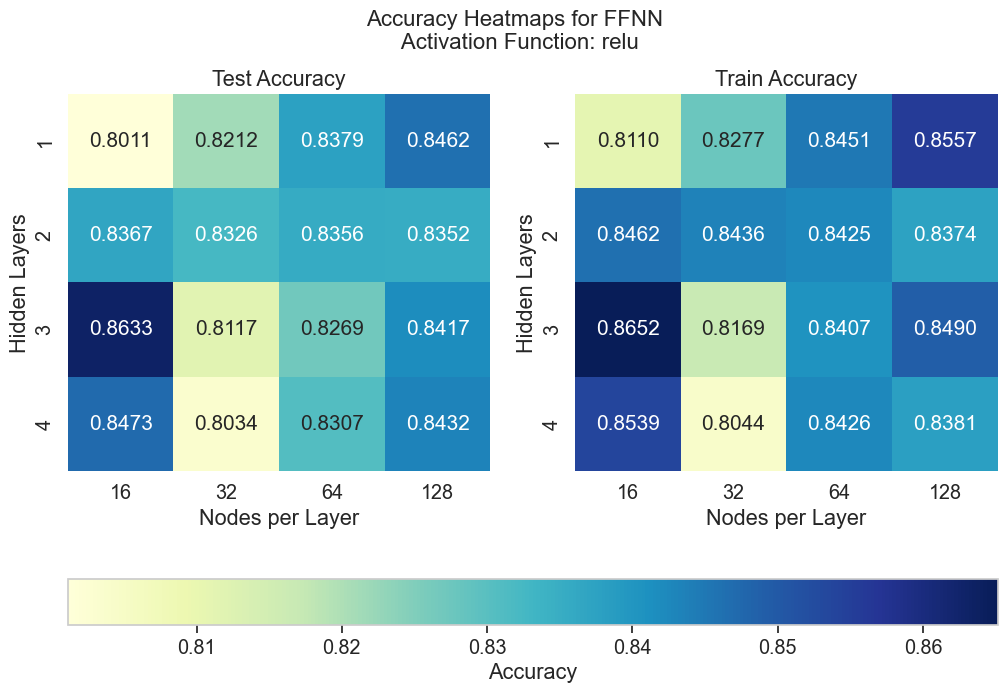

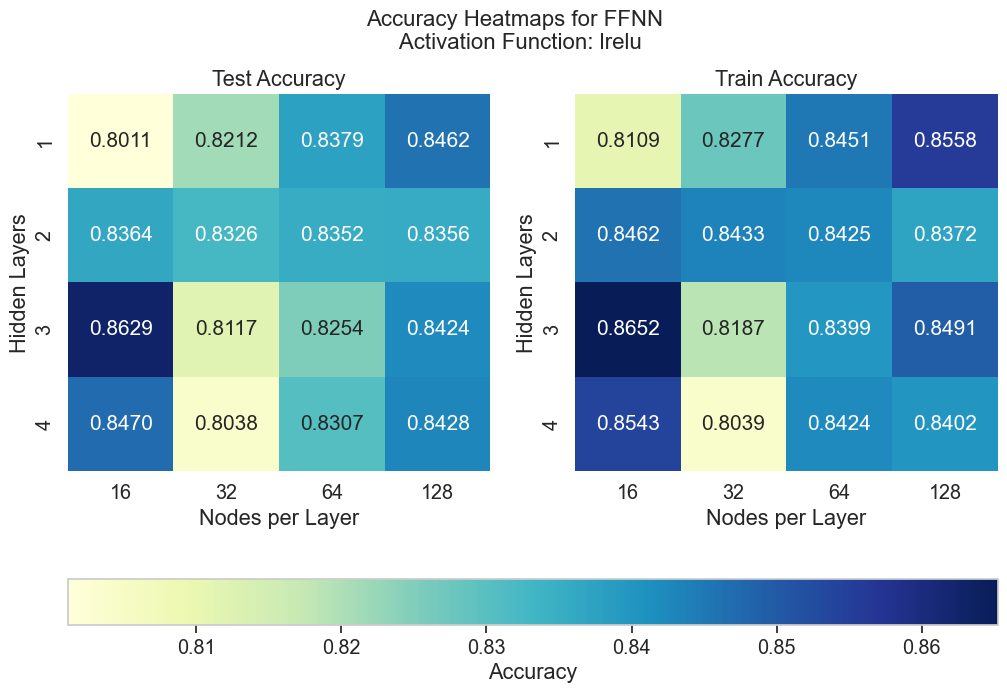

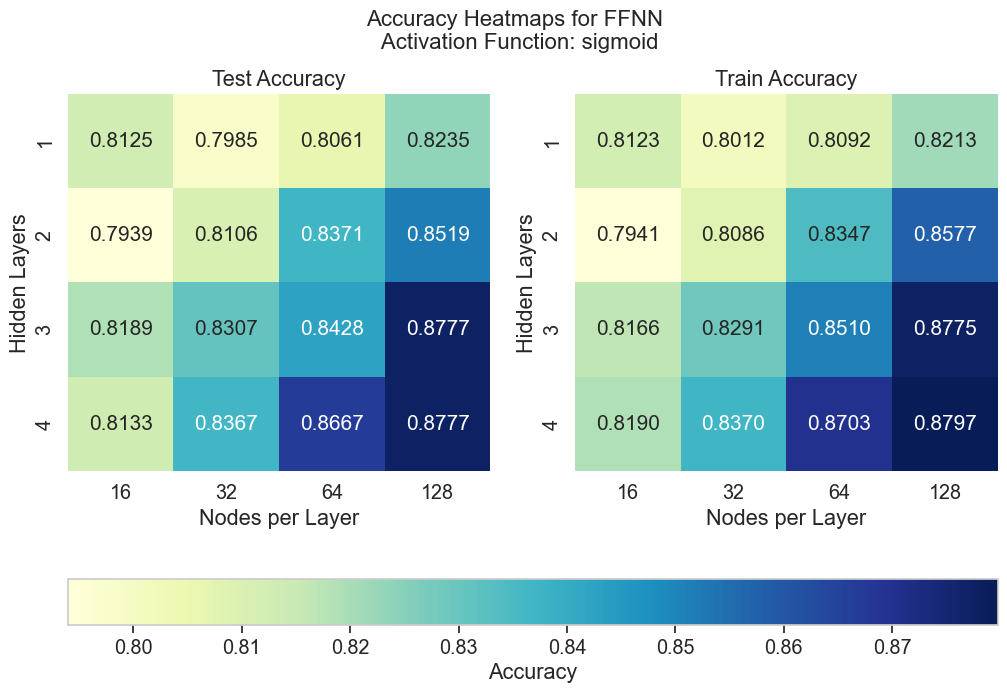

In [10]:
plt.rcParams.update({"font.size": 15})

for activation, activation_name in zip(activations, activation_names):

    fig, ax = plt.subplots(1, 2, figsize=(12, 7))

    fig.suptitle(f'Accuracy Heatmaps for FFNN \n Activation Function: {activation_name}', y = 1.0, fontsize=16)
    pivot_table_test = results_ffnn_arch[results_ffnn_arch['Activation'] == activation_name].pivot_table(
        index="Hidden Layers", columns="Nodes", values="Accuracy_test", aggfunc="mean")
    
    pivot_table_train = results_ffnn_arch[results_ffnn_arch['Activation'] == activation_name].pivot_table(
        index="Hidden Layers", columns="Nodes", values="Accuracy_train", aggfunc="mean")

    # Shared vmin/vmax across both heatmaps
    vmin = min(pivot_table_test.min().min(), pivot_table_train.min().min())
    vmax = max(pivot_table_test.max().max(), pivot_table_train.max().max())

    im1 = sns.heatmap(pivot_table_test, annot=True, fmt=".4f", cmap="YlGnBu", ax=ax[0], vmin=vmin, vmax=vmax, cbar=False)
    ax[0].set_title(f'Test Accuracy')
    ax[0].set_xlabel('Nodes per Layer')
    ax[0].set_ylabel('Hidden Layers')

    im2 = sns.heatmap(pivot_table_train, annot=True, fmt=".4f", cmap="YlGnBu", ax=ax[1], vmin=vmin, vmax=vmax, cbar=False)
    ax[1].set_title(f'Train Accuracy')
    ax[1].set_xlabel('Nodes per Layer')
    ax[1].set_ylabel('Hidden Layers')

    cbar = fig.colorbar(im2.get_children()[0], ax=ax, orientation="horizontal", pad=0.2, fraction=0.1)
    cbar.set_label('Accuracy')

    plt.show()

    fig.savefig(f'{figpath}/FFNN_Accuracy_Heatmap_{activation_name}.pdf', dpi=200, bbox_inches='tight')

In [11]:
best_model_ffnn_arch = results_ffnn_arch.loc[results_ffnn_arch.groupby('Activation')['Accuracy_test'].idxmax()]
best_model_ffnn_arch

,Activation,Hidden Layers,Nodes,Accuracy_train,Accuracy_test
24,lrelu,3,16,0.865246,0.862879
8,relu,3,16,0.865152,0.863258
43,sigmoid,3,128,0.877462,0.877652


### 2) Assessing the impact of learning rate and epoch size on accuracy

Here we inherit the best architectures found for each activation function, and explore how different learning rates and number of epochs affect the accuracy.

In [12]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.2]
epoch_options = [20, 50, 100, 200, 500]
activations = [RELU, LRELU, sigmoid]
activation_names = ['relu', 'lrelu', 'sigmoid']

In [13]:
results = []

for activation, activation_name in zip(activations, activation_names):
    for lr in learning_rates:
        for epochs in epoch_options:
            # Get the best architecture for the given activation function
            hidden = int(best_model_ffnn_arch[best_model_ffnn_arch['Activation'] == activation_name]['Hidden Layers'])
            nodes  = int(best_model_ffnn_arch[best_model_ffnn_arch['Activation'] == activation_name]['Nodes'])
    
            # Make lists of activation functions and their derivatives
            # Output layer uses softmax activation
            activation_funcs = [activation] * hidden + [softmax]
            activation_ders  = [derivate(activation)] * hidden + [derivate(softmax)]
            
            # Make a model for a given set of hyperparameters
            model = NeuralNetwork(
            network_input_size=X_train.shape[1],
            layer_output_sizes=[nodes] * hidden + [4],
            activation_funcs=activation_funcs,
            activation_ders=activation_ders,
            cost_fun=cross_entropy,
            cost_der=cross_entropy_der)

            # Train network with stochastic gradient descent and Adam optimizer
            model.train_SGD(X_train, y_train, epochs=epochs, learning_rate=lr, batch_size=batch_size, optimizer='adam')

            # Make predictions
            y_pred_test = model._feed_forward(X_test)
            y_pred_train = model._feed_forward(X_train)

            # Compute accuracy
            accuracy_train = evaluate_ffnn_classification(y_pred_train, y_train)
            accuracy_test  = evaluate_ffnn_classification(y_pred_test, y_test)

            print(f'Activation: {activation_name}, Learning Rate: {lr}, Epochs: {epochs}, Test Accuracy: {accuracy_test:.4f}')

            results.append({
                'Activation': activation_name,
                'Learning rate': lr,
                'Epochs': epochs,
                'Accuracy_train': accuracy_train,
                'Accuracy_test': accuracy_test})

/var/folders/tp/bn0hk5sx7fq7r171hlv9tzq40000gn/T/ipykernel_38702/696028426.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  hidden = int(best_model_ffnn_arch[best_model_ffnn_arch['Activation'] == activation_name]['Hidden Layers'])
/var/folders/tp/bn0hk5sx7fq7r171hlv9tzq40000gn/T/ipykernel_38702/696028426.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  nodes  = int(best_model_ffnn_arch[best_model_ffnn_arch['Activation'] == activation_name]['Nodes'])


Activation: relu, Learning Rate: 0.0001, Epochs: 20, Test Accuracy: 0.3280
Activation: relu, Learning Rate: 0.0001, Epochs: 50, Test Accuracy: 0.5890
Activation: relu, Learning Rate: 0.0001, Epochs: 100, Test Accuracy: 0.6909
Activation: relu, Learning Rate: 0.0001, Epochs: 200, Test Accuracy: 0.7996
Activation: relu, Learning Rate: 0.0001, Epochs: 500, Test Accuracy: 0.8648
Activation: relu, Learning Rate: 0.001, Epochs: 20, Test Accuracy: 0.7913
Activation: relu, Learning Rate: 0.001, Epochs: 50, Test Accuracy: 0.8633
Activation: relu, Learning Rate: 0.001, Epochs: 100, Test Accuracy: 0.8750
Activation: relu, Learning Rate: 0.001, Epochs: 200, Test Accuracy: 0.8818
Activation: relu, Learning Rate: 0.001, Epochs: 500, Test Accuracy: 0.8890
Activation: relu, Learning Rate: 0.01, Epochs: 20, Test Accuracy: 0.8841
Activation: relu, Learning Rate: 0.01, Epochs: 50, Test Accuracy: 0.8947
Activation: relu, Learning Rate: 0.01, Epochs: 100, Test Accuracy: 0.8936
Activation: relu, Learning Ra

In [14]:
results_ffnn_lrs = pd.DataFrame(results)

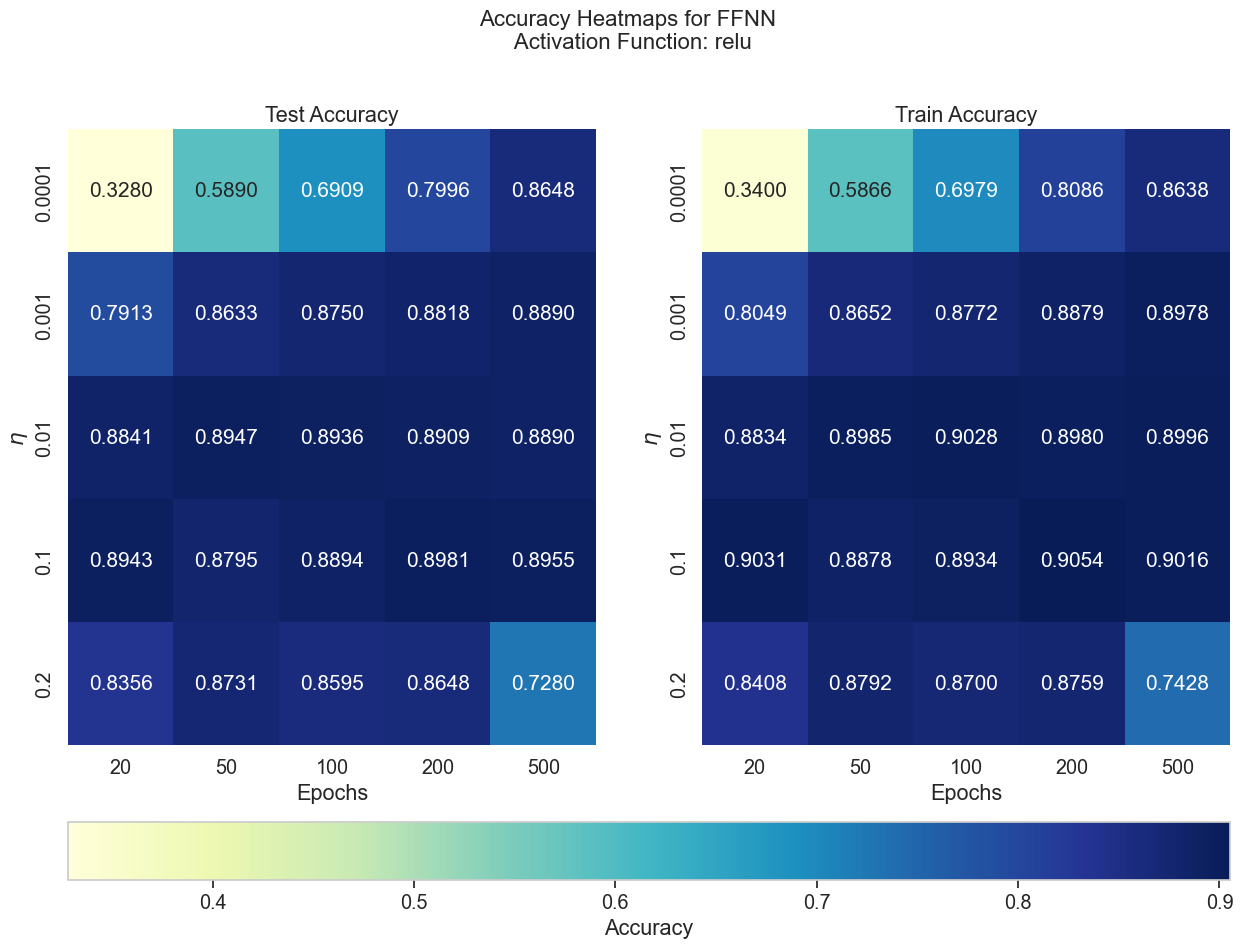

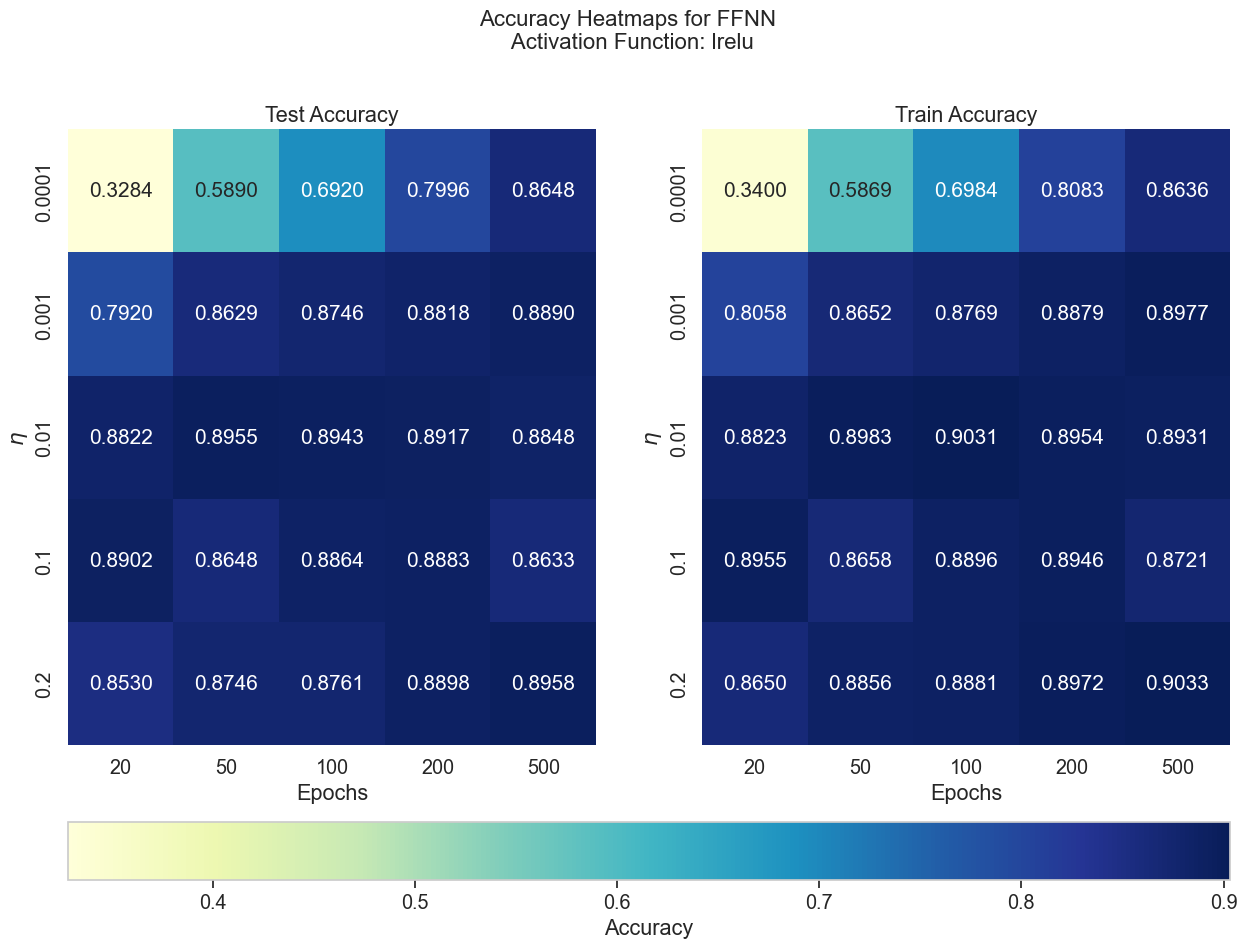

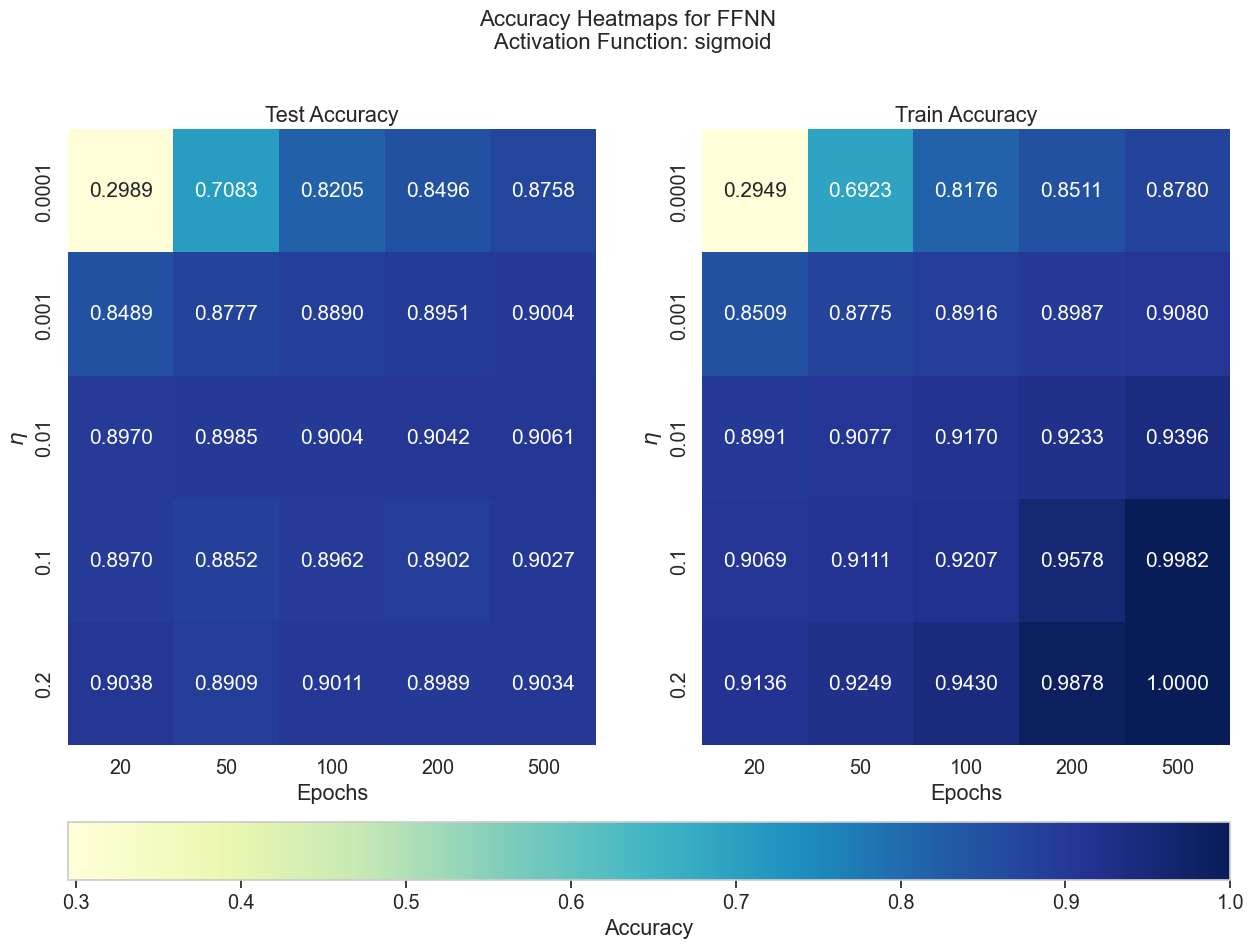

In [15]:
plt.rcParams.update({"font.size": 15})

for activation, activation_name in zip(activations, activation_names):

    fig, ax = plt.subplots(1, 2, figsize=(15, 10))

    fig.suptitle(f'Accuracy Heatmaps for FFNN \n Activation Function: {activation_name}', y = 1.0, fontsize=16)
    pivot_table_test = results_ffnn_lrs[results_ffnn_lrs['Activation'] == activation_name].pivot_table(
        index="Learning rate", columns="Epochs", values="Accuracy_test", aggfunc="mean")
    
    pivot_table_train = results_ffnn_lrs[results_ffnn_lrs['Activation'] == activation_name].pivot_table(
        index="Learning rate", columns="Epochs", values="Accuracy_train", aggfunc="mean")

    # Shared vmin/vmax across both heatmaps
    vmin = min(pivot_table_test.min().min(), pivot_table_train.min().min())
    vmax = max(pivot_table_test.max().max(), pivot_table_train.max().max())

    im1 = sns.heatmap(pivot_table_test, annot=True, fmt=".4f", cmap="YlGnBu", ax=ax[0], vmin=vmin, vmax=vmax, cbar=False)
    ax[0].set_title(f'Test Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel(r'$\eta$')

    im2 = sns.heatmap(pivot_table_train, annot=True, fmt=".4f", cmap="YlGnBu", ax=ax[1], vmin=vmin, vmax=vmax, cbar=False)
    ax[1].set_title(f'Train Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel(r'$\eta$')
    
    cbar = fig.colorbar(im2.get_children()[0], ax=ax, orientation="horizontal", pad=0.1, fraction=0.1)
    cbar.set_label('Accuracy')

    plt.show()

    fig.savefig(f'{figpath}/FFNN_Accuracy_Heatmap_LR_Epochs_{activation_name}.pdf', dpi=200, bbox_inches='tight')

In [16]:
best_model_ffnn_lrs = results_ffnn_lrs.loc[results_ffnn_lrs.groupby('Activation')['Accuracy_test'].idxmax()]
best_model_ffnn_lrs

,Activation,Learning rate,Epochs,Accuracy_train,Accuracy_test
49,lrelu,0.20,500,0.903314,0.895833
18,relu,0.10,200,0.905398,0.898106
64,sigmoid,0.01,500,0.939583,0.906061


### 3) Adding L1 and L2 regularization

Lastly, we train our PyTorch network with the best found acrhitecutre per activation and the best learning rate and epochs (for each activation respectively), but add regularization terms to penalize weights and help mitigate overfitting. We find this interesting to test as we know there are outliers in our dataset.

In [17]:
nlambdas = 4  # number of different regularization parameters
lambdas = np.logspace(-6, -3, nlambdas)

reg_options = ["L1", "L2"]

In [18]:
results = []

for activation, activation_name in zip(activations, activation_names):
    for reg in reg_options:
        for lmb in lambdas:

            hidden = int(best_model_ffnn_arch[best_model_ffnn_arch['Activation'] == activation_name]['Hidden Layers'])
            nodes  = int(best_model_ffnn_arch[best_model_ffnn_arch['Activation'] == activation_name]['Nodes'])
            lr = float(best_model_ffnn_lrs[best_model_ffnn_lrs['Activation'] == activation_name]['Learning rate'])
            epochs = int(best_model_ffnn_lrs[best_model_ffnn_lrs['Activation'] == activation_name]['Epochs'])

            # Make lists of activation functions and their derivatives
            # Output layer uses softmax activation
            activation_funcs = [activation] * hidden + [softmax]
            activation_ders  = [derivate(activation)] * hidden + [derivate(softmax)]
            
            # Make a model for a given set of hyperparameters
            model = NeuralNetwork(
            network_input_size=X_train.shape[1],
            layer_output_sizes=[nodes] * hidden + [4],
            activation_funcs=activation_funcs,
            activation_ders=activation_ders,
            cost_fun=cross_entropy,
            cost_der=cross_entropy_der,
            lamb=lmb,
            cost_fun_type=reg)

            # Train network with stochastic gradient descent and Adam optimizer
            model.train_SGD(X_train, y_train, epochs=epochs, learning_rate=lr, batch_size=batch_size, optimizer='adam')

            # Make predictions
            y_pred_test = model._feed_forward(X_test)
            y_pred_train = model._feed_forward(X_train)

            # Compute accuracy
            accuracy_train = evaluate_ffnn_classification(y_pred_train, y_train)
            accuracy_test  = evaluate_ffnn_classification(y_pred_test, y_test)

            print(f'Activation: {activation_name}, Reg: {reg}, Lambda: {lmb}, Test Accuracy: {accuracy_test:.4f}')

            results.append({
                'Activation': activation_name,
                'Reg': reg,
                'Lambda': lmb,
                'Accuracy_train': accuracy_train,
                'Accuracy_test': accuracy_test})

/var/folders/tp/bn0hk5sx7fq7r171hlv9tzq40000gn/T/ipykernel_38702/3990089648.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  hidden = int(best_model_ffnn_arch[best_model_ffnn_arch['Activation'] == activation_name]['Hidden Layers'])
/var/folders/tp/bn0hk5sx7fq7r171hlv9tzq40000gn/T/ipykernel_38702/3990089648.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  nodes  = int(best_model_ffnn_arch[best_model_ffnn_arch['Activation'] == activation_name]['Nodes'])
/var/folders/tp/bn0hk5sx7fq7r171hlv9tzq40000gn/T/ipykernel_38702/3990089648.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lr = float(best_model_ffnn_lrs[best_model_ffnn_lrs['Activation'] == activation_name]['Learning rate'])
/var/folders/tp/bn

Activation: relu, Reg: L1, Lambda: 1e-06, Test Accuracy: 0.8913
Activation: relu, Reg: L1, Lambda: 1e-05, Test Accuracy: 0.8890
Activation: relu, Reg: L1, Lambda: 0.0001, Test Accuracy: 0.8803
Activation: relu, Reg: L1, Lambda: 0.001, Test Accuracy: 0.8860
Activation: relu, Reg: L2, Lambda: 1e-06, Test Accuracy: 0.8917
Activation: relu, Reg: L2, Lambda: 1e-05, Test Accuracy: 0.8898
Activation: relu, Reg: L2, Lambda: 0.0001, Test Accuracy: 0.8913
Activation: relu, Reg: L2, Lambda: 0.001, Test Accuracy: 0.8951
Activation: lrelu, Reg: L1, Lambda: 1e-06, Test Accuracy: 0.8966
Activation: lrelu, Reg: L1, Lambda: 1e-05, Test Accuracy: 0.8686
Activation: lrelu, Reg: L1, Lambda: 0.0001, Test Accuracy: 0.8792
Activation: lrelu, Reg: L1, Lambda: 0.001, Test Accuracy: 0.8902
Activation: lrelu, Reg: L2, Lambda: 1e-06, Test Accuracy: 0.8504
Activation: lrelu, Reg: L2, Lambda: 1e-05, Test Accuracy: 0.8788
Activation: lrelu, Reg: L2, Lambda: 0.0001, Test Accuracy: 0.8780
Activation: lrelu, Reg: L2, L

In [19]:
results_ffnn_reg = pd.DataFrame(results)

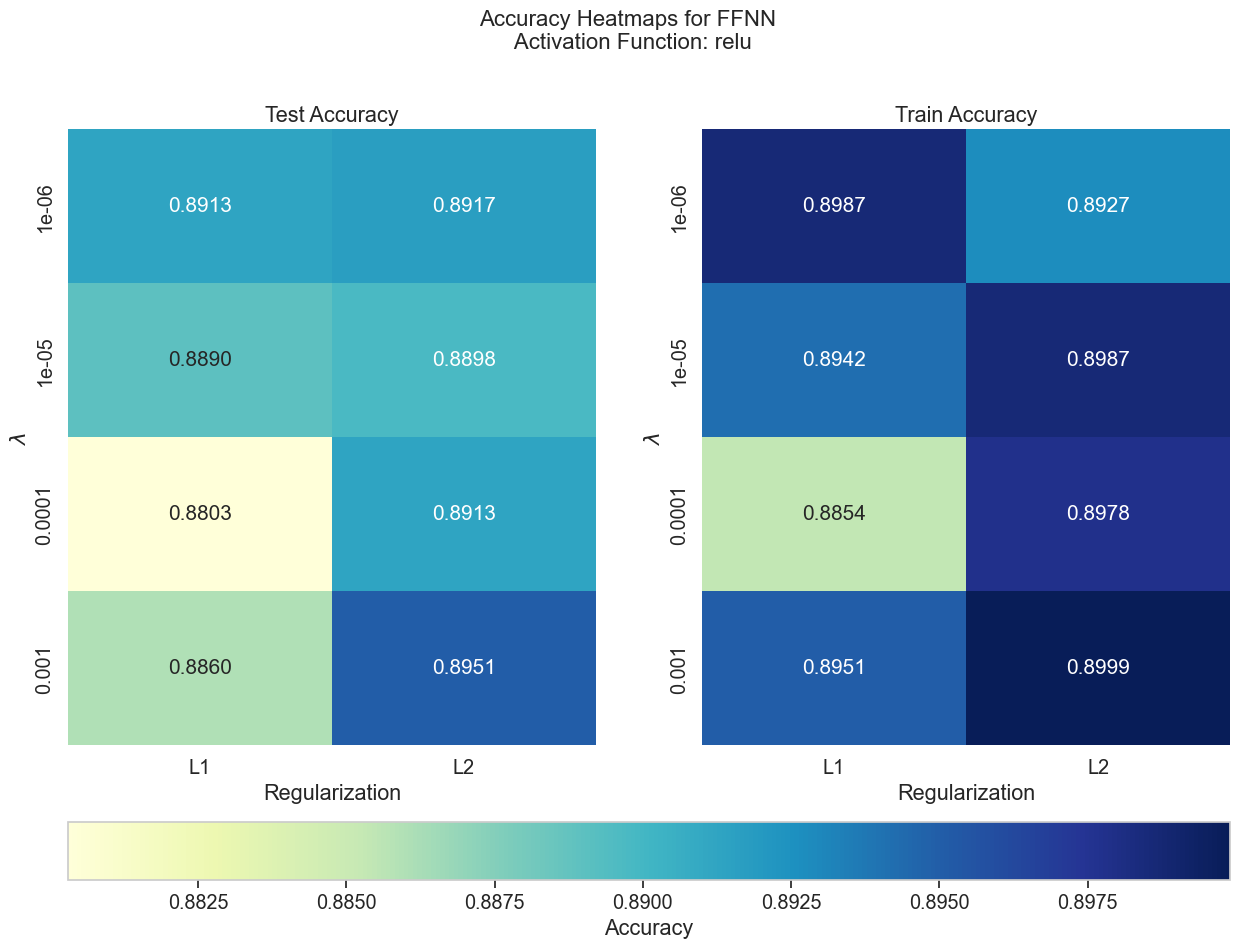

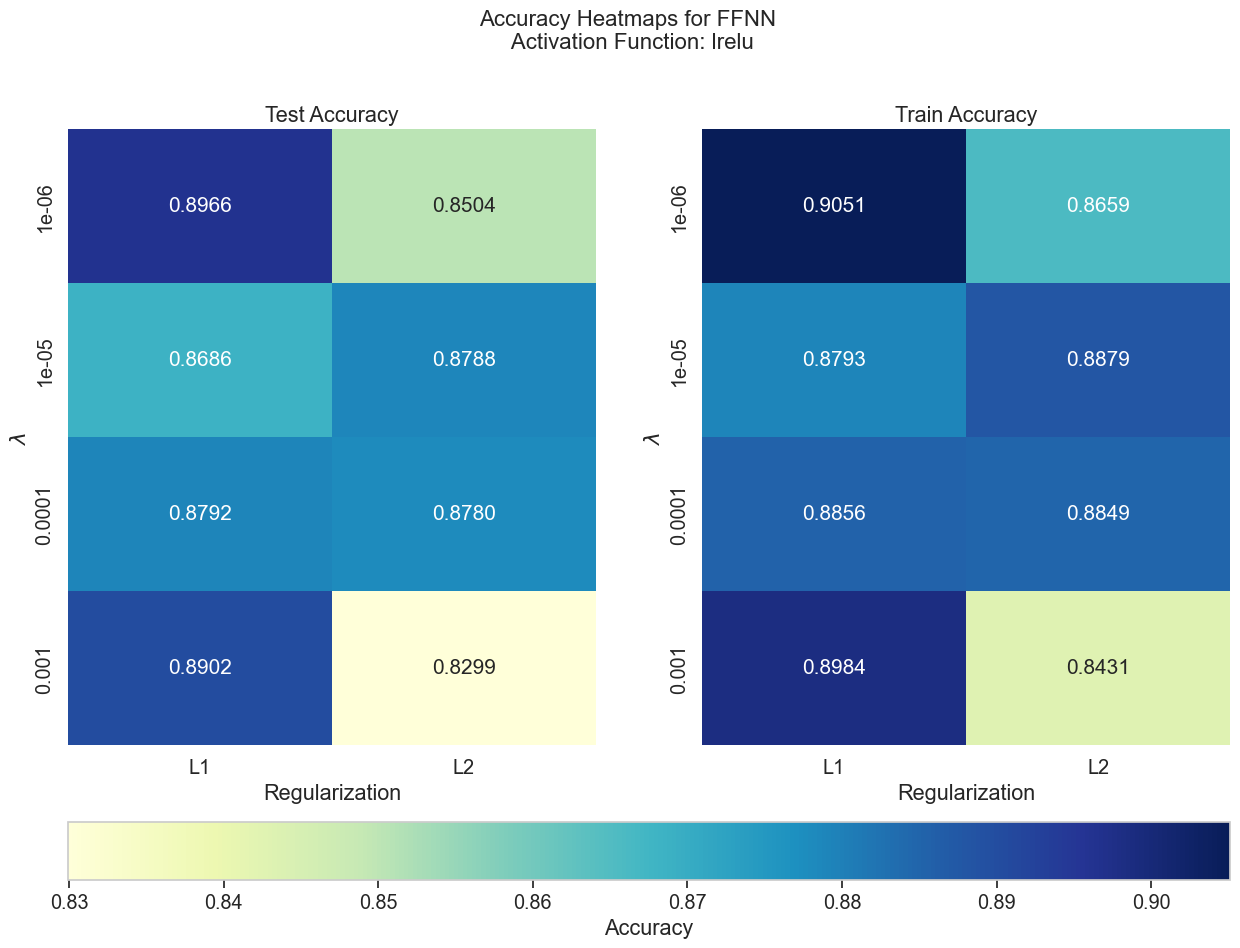

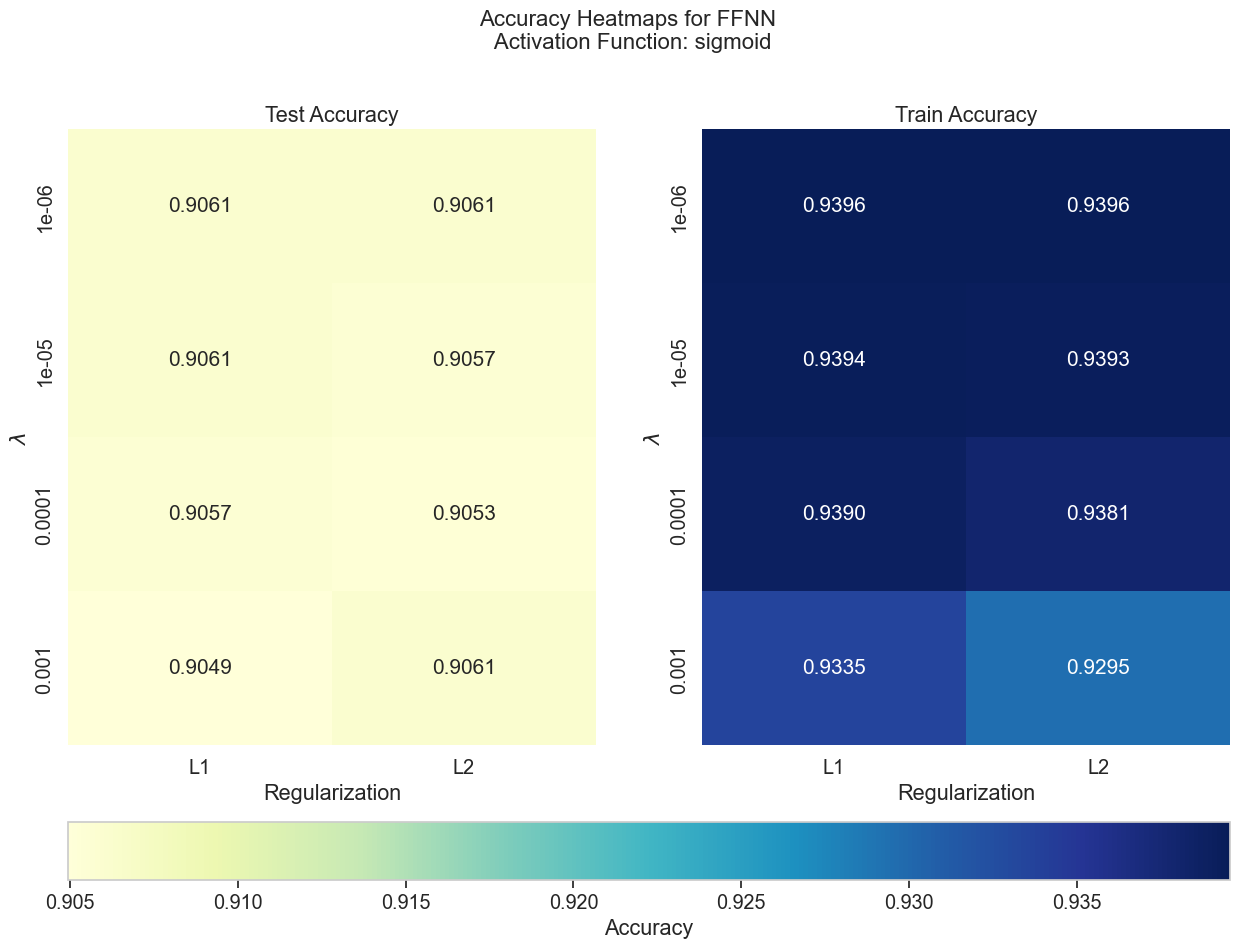

In [20]:
plt.rcParams.update({"font.size": 15})

for activation, activation_name in zip(activations, activation_names):

    fig, ax = plt.subplots(1, 2, figsize=(15, 10))

    fig.suptitle(f'Accuracy Heatmaps for FFNN \n Activation Function: {activation_name}', y = 1.0, fontsize=16)
    pivot_table_test = results_ffnn_reg[results_ffnn_reg['Activation'] == activation_name].pivot_table(
        index="Lambda", columns="Reg", values="Accuracy_test", aggfunc="mean")
    
    pivot_table_train = results_ffnn_reg[results_ffnn_reg['Activation'] == activation_name].pivot_table(
        index="Lambda", columns="Reg", values="Accuracy_train", aggfunc="mean")

    # Shared vmin/vmax across both heatmaps
    vmin = min(pivot_table_test.min().min(), pivot_table_train.min().min())
    vmax = max(pivot_table_test.max().max(), pivot_table_train.max().max())

    im1 = sns.heatmap(pivot_table_test, annot=True, fmt=".4f", cmap="YlGnBu", ax=ax[0], vmin=vmin, vmax=vmax, cbar=False)
    ax[0].set_title(f'Test Accuracy')
    ax[0].set_xlabel('Regularization')
    ax[0].set_ylabel(r'$\lambda$')

    im2 = sns.heatmap(pivot_table_train, annot=True, fmt=".4f", cmap="YlGnBu", ax=ax[1], vmin=vmin, vmax=vmax, cbar=False)
    ax[1].set_title(f'Train Accuracy')
    ax[1].set_xlabel('Regularization')
    ax[1].set_ylabel(r'$\lambda$')
    
    cbar = fig.colorbar(im2.get_children()[0], ax=ax, orientation="horizontal", pad=0.1, fraction=0.1)
    cbar.set_label('Accuracy')

    plt.show()

    fig.savefig(f'{figpath}/FFNN_Accuracy_Heatmap_Lambda_Reg_{activation_name}.pdf', dpi=200, bbox_inches='tight')

In [21]:
best_model_ffnn_reg = results_ffnn_reg.loc[results_ffnn_reg.groupby('Activation')['Accuracy_test'].idxmax()]

# Weather type classification using a PyTorch neural network
We now repeat the same analysis done for our FFNN on our PyTorch NN.

In [22]:
# Initialize dataset
# Here we use the WeatherDataset class from make_dataset.py
# The data is scaled using MinMaxScaler from sklearn
dataset = WeatherDataset(csv_file=path)

# Same indices as for FFNN to ensure same train-test split
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

batch_size = 32

input_dim = dataset.X.shape[1]  # number of features
num_classes = len(dataset.encoders["Weather Type"].classes_)  # number of classes

# Load the data 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 1) Exploring different network architectures for different activation functions

We start by training our network using different network constructions in terms of number of hidden layers and number of nodes per layer. This is done for three different activation functions, ReLU, LReLU and sigmoid.

In [23]:
learning_rate = 0.001
activations = ['relu', 'lrelu', 'sigmoid']

num_hidden_layers = [1, 2, 3, 4]
num_of_nodes = [16, 32, 64, 128]

epochs = 50

In [24]:
results = []

for activation in activations:
    for hidden in num_hidden_layers:
        for nodes in num_of_nodes:
            
            # Make a model for a given set of hyperparameters
            model = WeatherNN(input_dim=input_dim, hidden_dim=nodes, num_hidden_layers=hidden, output_dim=num_classes, activation=activation)

            # Train the model
            training_model = model.train_model(train_loader, learning_rate, epochs)

            # Evalute accuracy of model
            accuracy_train = model.evaluate(train_loader)
            accuracy_test  = model.evaluate(test_loader)

            print(f'Activation: {activation}, Hidden Layers: {hidden}, Nodes: {nodes}, Test Accuracy: {accuracy_test:.4f}')

            results.append({
                'Activation': activation,
                'Hidden Layers': hidden,
                'Nodes': nodes,
                'Accuracy_train': accuracy_train,
                'Accuracy_test': accuracy_test})

Activation: relu, Hidden Layers: 1, Nodes: 16, Test Accuracy: 0.9008
Activation: relu, Hidden Layers: 1, Nodes: 32, Test Accuracy: 0.8970
Activation: relu, Hidden Layers: 1, Nodes: 64, Test Accuracy: 0.9015
Activation: relu, Hidden Layers: 1, Nodes: 128, Test Accuracy: 0.9053
Activation: relu, Hidden Layers: 2, Nodes: 16, Test Accuracy: 0.9042
Activation: relu, Hidden Layers: 2, Nodes: 32, Test Accuracy: 0.9030
Activation: relu, Hidden Layers: 2, Nodes: 64, Test Accuracy: 0.9008
Activation: relu, Hidden Layers: 2, Nodes: 128, Test Accuracy: 0.9114
Activation: relu, Hidden Layers: 3, Nodes: 16, Test Accuracy: 0.9027
Activation: relu, Hidden Layers: 3, Nodes: 32, Test Accuracy: 0.9045
Activation: relu, Hidden Layers: 3, Nodes: 64, Test Accuracy: 0.9102
Activation: relu, Hidden Layers: 3, Nodes: 128, Test Accuracy: 0.9121
Activation: relu, Hidden Layers: 4, Nodes: 16, Test Accuracy: 0.9045
Activation: relu, Hidden Layers: 4, Nodes: 32, Test Accuracy: 0.9049
Activation: relu, Hidden Layers

In [25]:
results_torch_arch = pd.DataFrame(results)

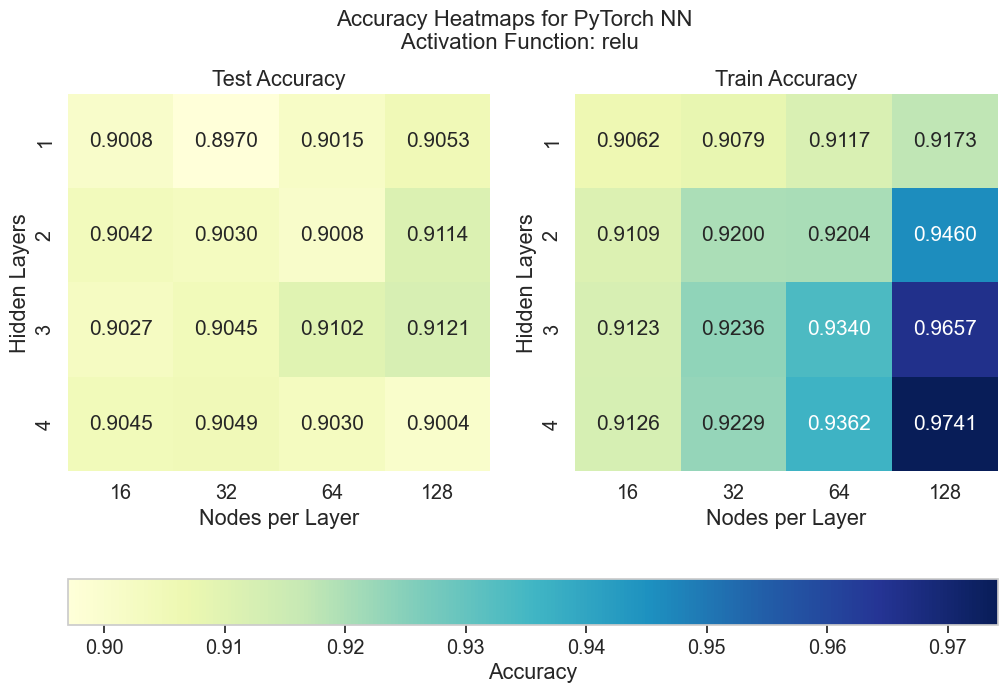

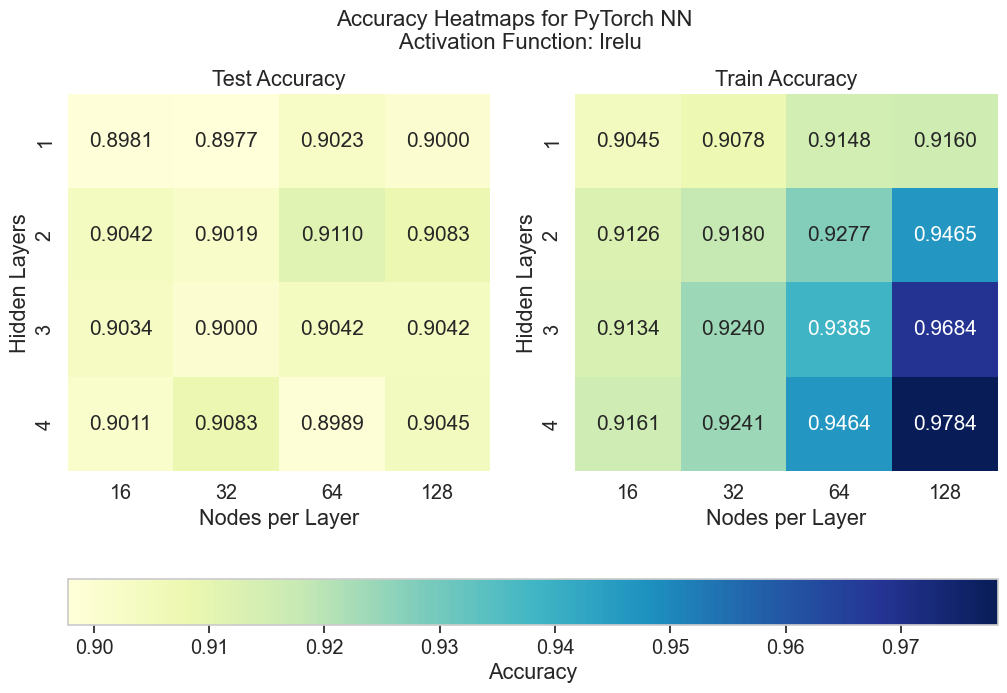

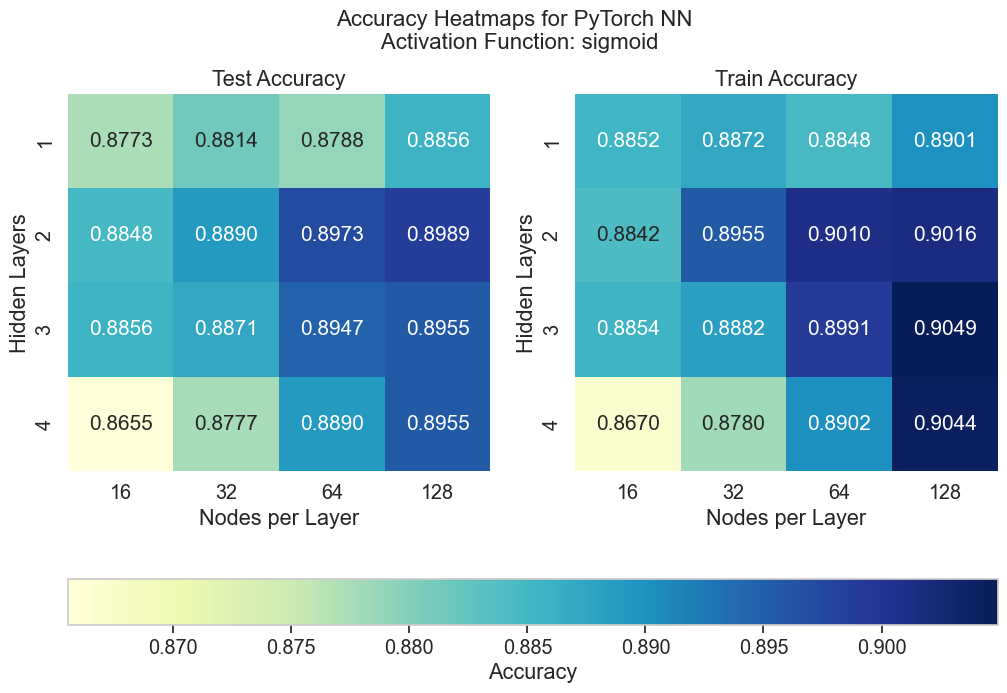

In [26]:
plt.rcParams.update({"font.size": 15})

for activation in activations:

    fig, ax = plt.subplots(1, 2, figsize=(12, 7))

    fig.suptitle(f'Accuracy Heatmaps for PyTorch NN \n Activation Function: {activation}', y = 1.0, fontsize=16)

    pivot_table_test = results_torch_arch[results_torch_arch['Activation'] == activation].pivot_table(
        index="Hidden Layers", columns="Nodes", values="Accuracy_test", aggfunc="mean")
    
    pivot_table_train = results_torch_arch[results_torch_arch['Activation'] == activation].pivot_table(
        index="Hidden Layers", columns="Nodes", values="Accuracy_train", aggfunc="mean")

    # Shared vmin/vmax across both heatmaps
    vmin = min(pivot_table_test.min().min(), pivot_table_train.min().min())
    vmax = max(pivot_table_test.max().max(), pivot_table_train.max().max())

    im1 = sns.heatmap(pivot_table_test, annot=True, fmt=".4f", cmap="YlGnBu", ax=ax[0], vmin=vmin, vmax=vmax, cbar=False)
    ax[0].set_title(f'Test Accuracy')
    ax[0].set_xlabel('Nodes per Layer')
    ax[0].set_ylabel('Hidden Layers')

    im2 = sns.heatmap(pivot_table_train, annot=True, fmt=".4f", cmap="YlGnBu", ax=ax[1], vmin=vmin, vmax=vmax, cbar=False)
    ax[1].set_title(f'Train Accuracy')
    ax[1].set_xlabel('Nodes per Layer')
    ax[1].set_ylabel('Hidden Layers')

    cbar = fig.colorbar(im2.get_children()[0], ax=ax, orientation="horizontal", pad=0.2, fraction=0.1)
    cbar.set_label('Accuracy')

    plt.show()
    fig.savefig(f'{figpath}/PytorchNN_Accuracy_Heatmap_{activation}.pdf', dpi=200, bbox_inches='tight')


In [27]:
# Fidning the best architecture per activation function
best_torch_model_arch = results_torch_arch.loc[results_torch_arch.groupby('Activation')['Accuracy_test'].idxmax()]
best_torch_model_arch

,Activation,Hidden Layers,Nodes,Accuracy_train,Accuracy_test
22,lrelu,2,64,0.927652,0.910985
11,relu,3,128,0.965720,0.912121
39,sigmoid,2,128,0.901610,0.898864


### 2) Assessing the impact of learning rate and epoch size on accuracy

Here we inherit the best architectures found for each activation function, and explore how different learning rates and number of epochs affect the accuracy.

In [28]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.2]
epoch_options = [20, 50, 100, 200, 500]
activations = ['relu', 'lrelu', 'sigmoid']

In [29]:
results = []

for activation in activations:
    for lr in learning_rates:
        for epochs in epoch_options:

            # Get the best architecture for the given activation function
            num_hidden_layers = int(best_torch_model_arch[best_torch_model_arch['Activation'] == activation]['Hidden Layers'])
            num_of_nodes = int(best_torch_model_arch[best_torch_model_arch['Activation'] == activation]['Nodes'])

            # Make a model for a given set of hyperparameters
            model = WeatherNN(input_dim=input_dim, hidden_dim=num_of_nodes, num_hidden_layers=num_hidden_layers, output_dim=num_classes, activation=activation)

            # Train the model
            training_model = model.train_model(train_loader, lr, epochs)

            # Evalute accuracy of model
            accuracy_train = model.evaluate(train_loader)
            accuracy_test  = model.evaluate(test_loader)

            print(f'Activation: {activation}, Learning rate: {lr}, Number of epochs: {epochs}, Test Accuracy: {accuracy_test:.4f}')

            results.append({
                'Activation': activation,
                'Learning Rate': lr,
                'Epochs': epochs,
                'Accuracy_train': accuracy_train,
                'Accuracy_test': accuracy_test})

/var/folders/tp/bn0hk5sx7fq7r171hlv9tzq40000gn/T/ipykernel_38702/1883714739.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  num_hidden_layers = int(best_torch_model_arch[best_torch_model_arch['Activation'] == activation]['Hidden Layers'])
/var/folders/tp/bn0hk5sx7fq7r171hlv9tzq40000gn/T/ipykernel_38702/1883714739.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  num_of_nodes = int(best_torch_model_arch[best_torch_model_arch['Activation'] == activation]['Nodes'])


Activation: relu, Learning rate: 0.0001, Number of epochs: 20, Test Accuracy: 0.9011
Activation: relu, Learning rate: 0.0001, Number of epochs: 50, Test Accuracy: 0.9064
Activation: relu, Learning rate: 0.0001, Number of epochs: 100, Test Accuracy: 0.9057
Activation: relu, Learning rate: 0.0001, Number of epochs: 200, Test Accuracy: 0.9083
Activation: relu, Learning rate: 0.0001, Number of epochs: 500, Test Accuracy: 0.9083
Activation: relu, Learning rate: 0.001, Number of epochs: 20, Test Accuracy: 0.9053
Activation: relu, Learning rate: 0.001, Number of epochs: 50, Test Accuracy: 0.9030
Activation: relu, Learning rate: 0.001, Number of epochs: 100, Test Accuracy: 0.9053
Activation: relu, Learning rate: 0.001, Number of epochs: 200, Test Accuracy: 0.9076
Activation: relu, Learning rate: 0.001, Number of epochs: 500, Test Accuracy: 0.9061
Activation: relu, Learning rate: 0.01, Number of epochs: 20, Test Accuracy: 0.9004
Activation: relu, Learning rate: 0.01, Number of epochs: 50, Test 

In [30]:
results_torch_lrs = pd.DataFrame(results)

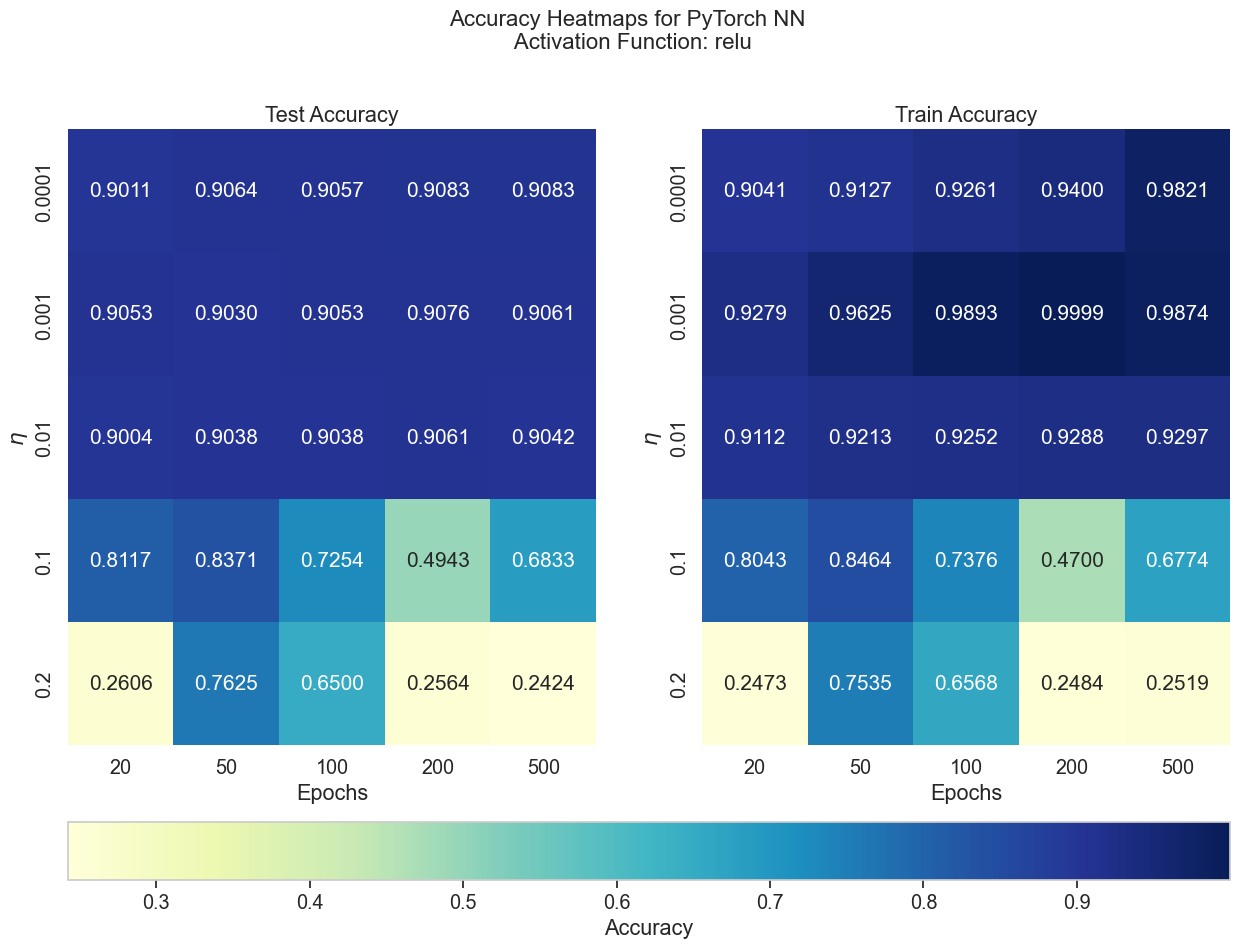

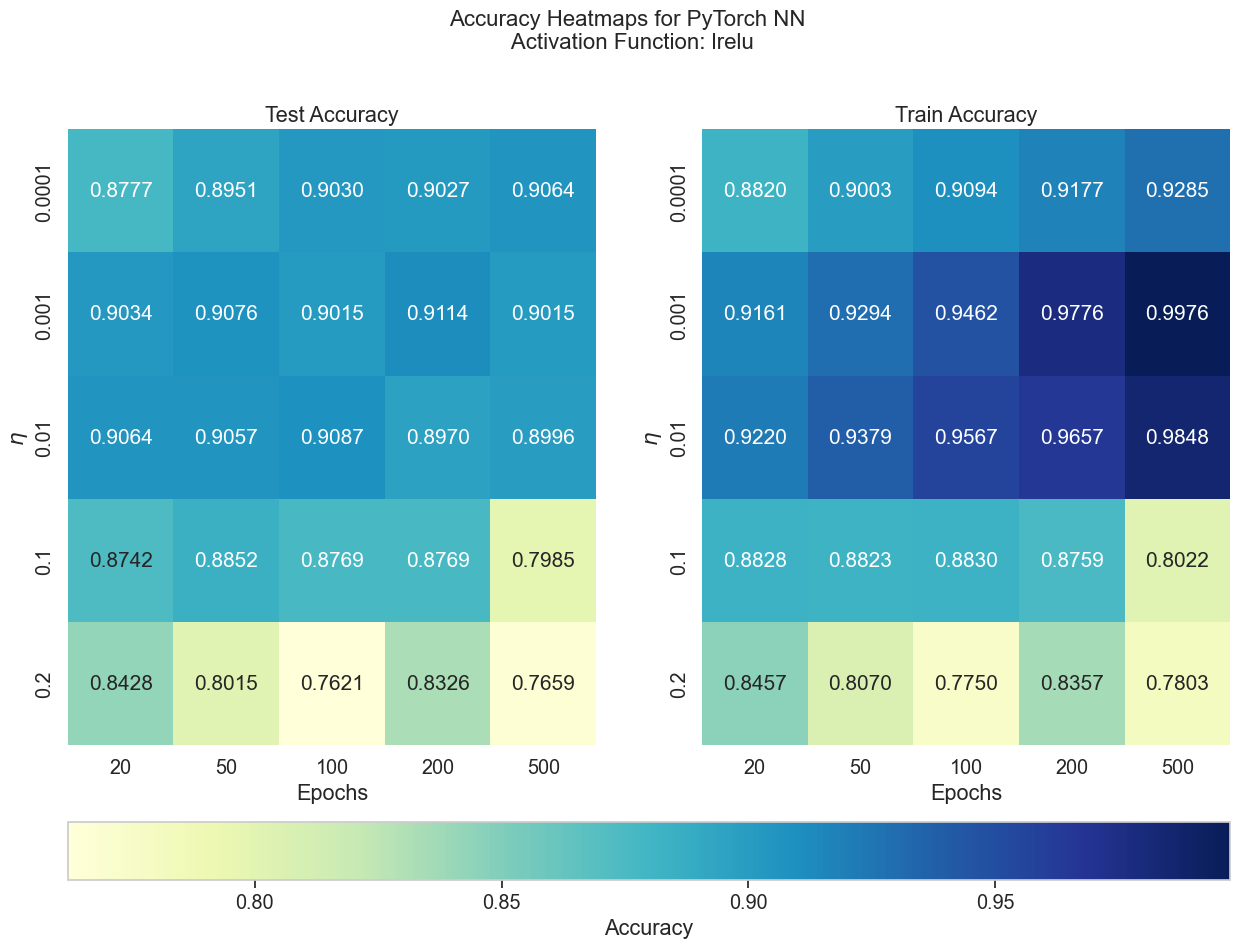

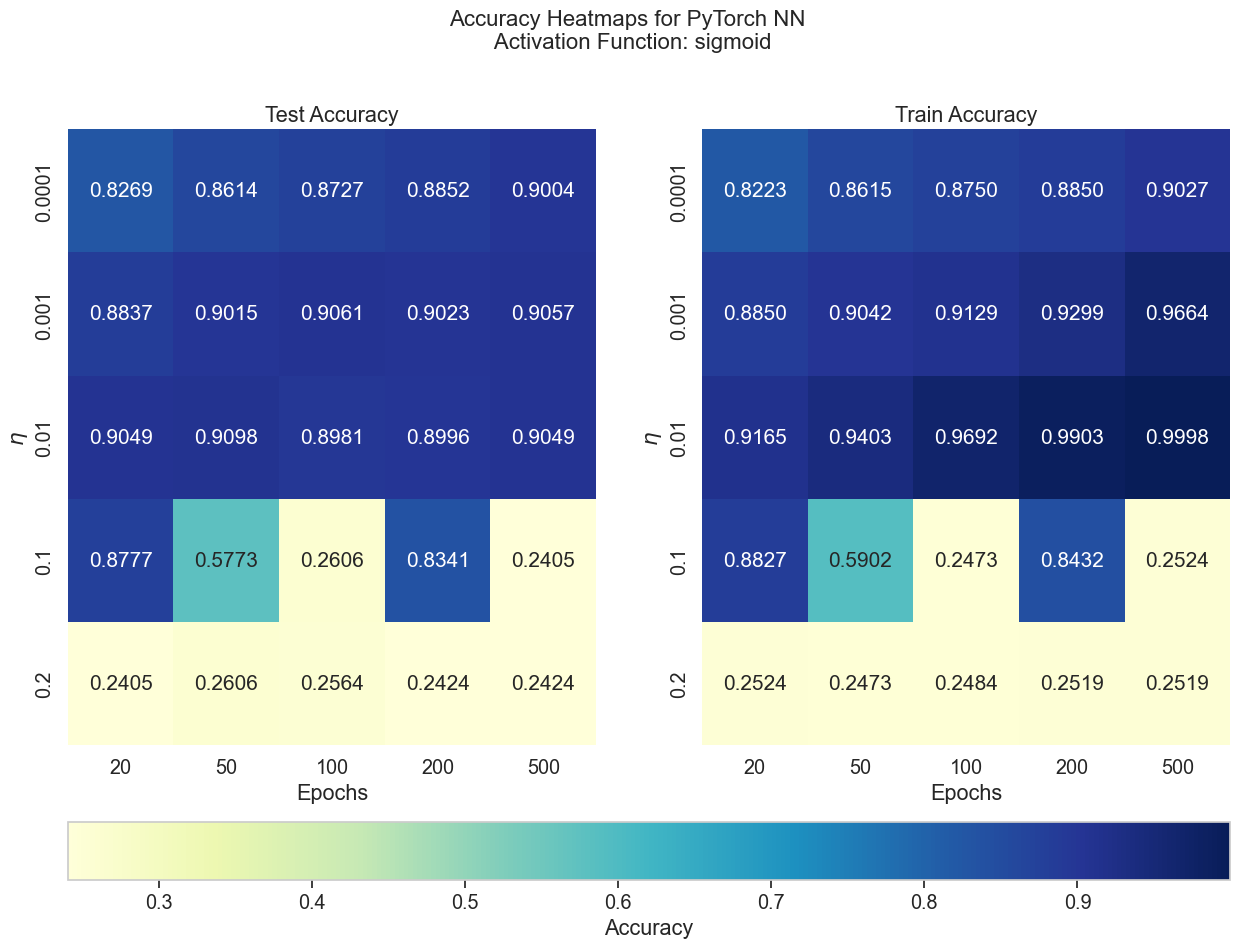

In [31]:
plt.rcParams.update({"font.size": 15})

for activation in activations:

    fig, ax = plt.subplots(1, 2, figsize=(15, 10))

    fig.suptitle(f'Accuracy Heatmaps for PyTorch NN \n Activation Function: {activation}', y = 1.0, fontsize=16)

    pivot_table_test = results_torch_lrs[results_torch_lrs['Activation'] == activation].pivot_table(
        index="Learning Rate", columns="Epochs", values="Accuracy_test", aggfunc="mean")
    
    pivot_table_train = results_torch_lrs[results_torch_lrs['Activation'] == activation].pivot_table(
        index="Learning Rate", columns="Epochs", values="Accuracy_train", aggfunc="mean")

    # Shared vmin/vmax across both heatmaps
    vmin = min(pivot_table_test.min().min(), pivot_table_train.min().min())
    vmax = max(pivot_table_test.max().max(), pivot_table_train.max().max())

    im1 = sns.heatmap(pivot_table_test, annot=True, fmt=".4f", cmap="YlGnBu", ax=ax[0], vmin=vmin, vmax=vmax, cbar=False)
    ax[0].set_title(f'Test Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel(r'$\eta$')

    im2 = sns.heatmap(pivot_table_train, annot=True, fmt=".4f", cmap="YlGnBu", ax=ax[1], vmin=vmin, vmax=vmax, cbar=False)
    ax[1].set_title(f'Train Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel(r'$\eta$')

    cbar = fig.colorbar(im2.get_children()[0], ax=ax, orientation="horizontal", pad=0.1, fraction=0.1)
    cbar.set_label('Accuracy')

    plt.show()
    fig.savefig(f'{figpath}/PytorchNN_Accuracy_Heatmap_LR_Epochs_{activation}.pdf', dpi=200, bbox_inches='tight')

So, by using the best model architectures in terms of number of layers and nodes per activation function, as seen below,

In [32]:
best_torch_model_arch

,Activation,Hidden Layers,Nodes,Accuracy_train,Accuracy_test
22,lrelu,2,64,0.927652,0.910985
11,relu,3,128,0.965720,0.912121
39,sigmoid,2,128,0.901610,0.898864


We get by adding different learning rates and epoch sizes, that the best models become:

In [33]:
best_model_torch_lrs = results_torch_lrs.loc[results_torch_lrs.groupby('Activation')['Accuracy_test'].idxmax()]
best_model_torch_lrs

,Activation,Learning Rate,Epochs,Accuracy_train,Accuracy_test
33,lrelu,0.0010,200,0.977557,0.911364
3,relu,0.0001,200,0.939962,0.908333
61,sigmoid,0.0100,50,0.940341,0.909848


### 3) Adding L1 and L2 regularization

Lastly, we train our PyTorch network with the best found acrhitecutre per activation and the best learning rate and epochs (for each activation respectively), but add regularization terms to penalize weights and help mitigate overfitting. We find this interesting to test as we know there are outliers in our dataset.



In [34]:
nlambdas = 4  # number of different regularization parameters
lambdas = np.logspace(-6, -3, nlambdas)

reg_options = ["L1", "L2"]

In [35]:
results = []

for activation in activations:
    for reg_type in reg_options:
        for lmb in lambdas:

            # Get the best architecture for the given activation function
            num_hidden_layers = int(best_torch_model_arch[best_torch_model_arch['Activation'] == activation]['Hidden Layers'])
            num_of_nodes = int(best_torch_model_arch[best_torch_model_arch['Activation'] == activation]['Nodes'])

            # Get the optimal learning rate and epoch size for the given activation function
            lr = float(best_model_torch_lrs[best_model_torch_lrs['Activation'] == activation]['Learning Rate'])
            epochs = int(best_model_torch_lrs[best_model_torch_lrs['Activation'] == activation]['Epochs'])

            # Make a model for a given set of hyperparameters
            model = WeatherNN(input_dim=input_dim, 
                              hidden_dim=num_of_nodes, 
                              num_hidden_layers=num_hidden_layers, 
                              output_dim=num_classes, 
                              activation=activation)

            # Train the model
            training_model = model.train_model(train_loader, lr, epochs, lmb, reg_type)

            # Evalute accuracy of model
            accuracy_train = model.evaluate(train_loader)
            accuracy_test  = model.evaluate(test_loader)

            print(f'Activation: {activation}, Reg: {reg_type}, Lambda: {lmb}, Test Accuracy: {accuracy_test:.4f}')

            results.append({
                'Activation': activation,
                'Reg': reg_type,
                'Lambda': lmb,
                'Accuracy_train': accuracy_train,
                'Accuracy_test': accuracy_test})

/var/folders/tp/bn0hk5sx7fq7r171hlv9tzq40000gn/T/ipykernel_38702/3918491971.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  num_hidden_layers = int(best_torch_model_arch[best_torch_model_arch['Activation'] == activation]['Hidden Layers'])
/var/folders/tp/bn0hk5sx7fq7r171hlv9tzq40000gn/T/ipykernel_38702/3918491971.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  num_of_nodes = int(best_torch_model_arch[best_torch_model_arch['Activation'] == activation]['Nodes'])
/var/folders/tp/bn0hk5sx7fq7r171hlv9tzq40000gn/T/ipykernel_38702/3918491971.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lr = float(best_model_torch_lrs[best_model_torch_lrs['Activation'] == activation]['Learning Rate'])
/var/fold

Activation: relu, Reg: L1, Lambda: 1e-06, Test Accuracy: 0.9027
Activation: relu, Reg: L1, Lambda: 1e-05, Test Accuracy: 0.9076
Activation: relu, Reg: L1, Lambda: 0.0001, Test Accuracy: 0.9083
Activation: relu, Reg: L1, Lambda: 0.001, Test Accuracy: 0.9008
Activation: relu, Reg: L2, Lambda: 1e-06, Test Accuracy: 0.9053
Activation: relu, Reg: L2, Lambda: 1e-05, Test Accuracy: 0.9057
Activation: relu, Reg: L2, Lambda: 0.0001, Test Accuracy: 0.9087
Activation: relu, Reg: L2, Lambda: 0.001, Test Accuracy: 0.9045
Activation: lrelu, Reg: L1, Lambda: 1e-06, Test Accuracy: 0.9008
Activation: lrelu, Reg: L1, Lambda: 1e-05, Test Accuracy: 0.9008
Activation: lrelu, Reg: L1, Lambda: 0.0001, Test Accuracy: 0.9091
Activation: lrelu, Reg: L1, Lambda: 0.001, Test Accuracy: 0.9045
Activation: lrelu, Reg: L2, Lambda: 1e-06, Test Accuracy: 0.9011
Activation: lrelu, Reg: L2, Lambda: 1e-05, Test Accuracy: 0.8989
Activation: lrelu, Reg: L2, Lambda: 0.0001, Test Accuracy: 0.9030
Activation: lrelu, Reg: L2, L

In [36]:
results_torch_reg = pd.DataFrame(results)

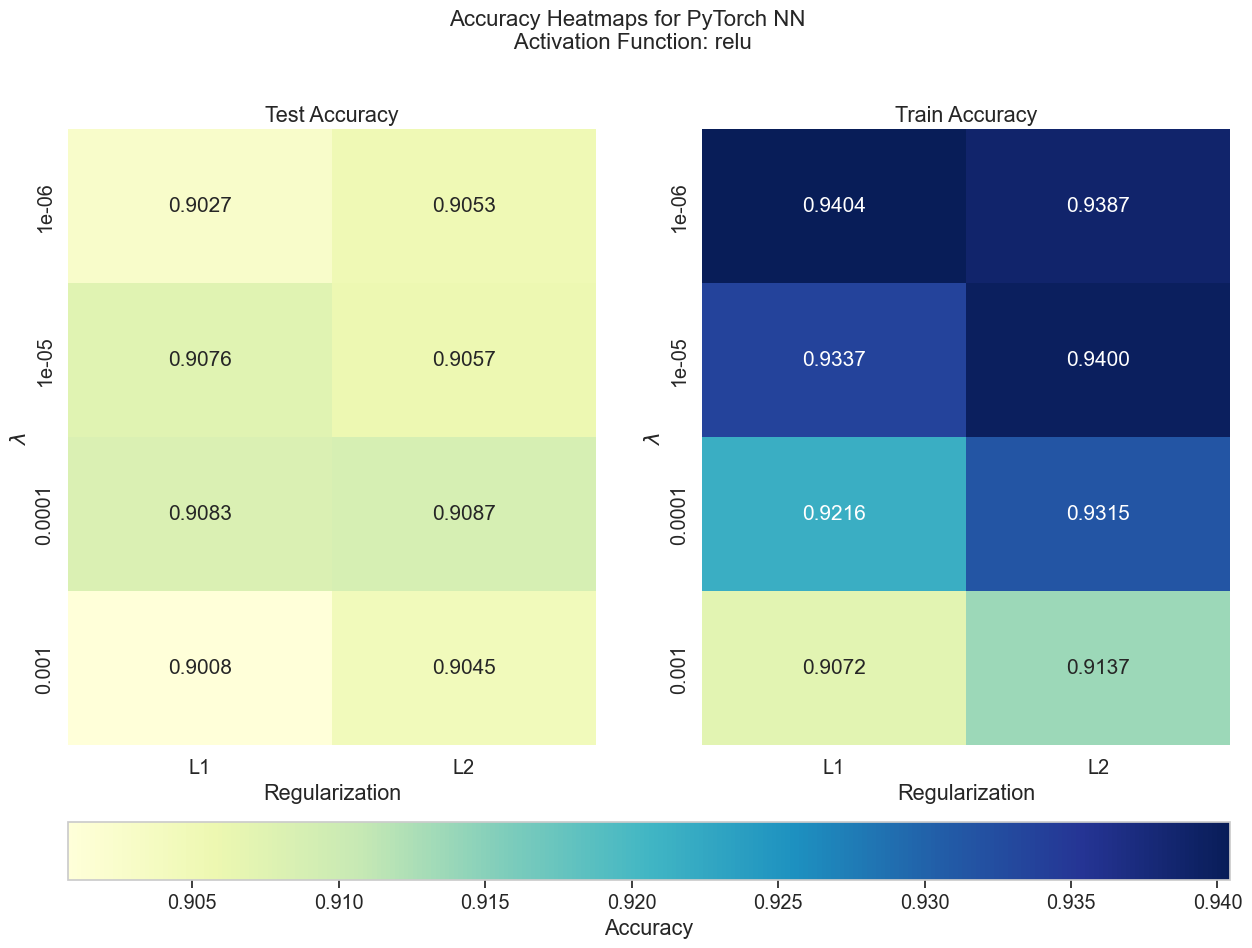

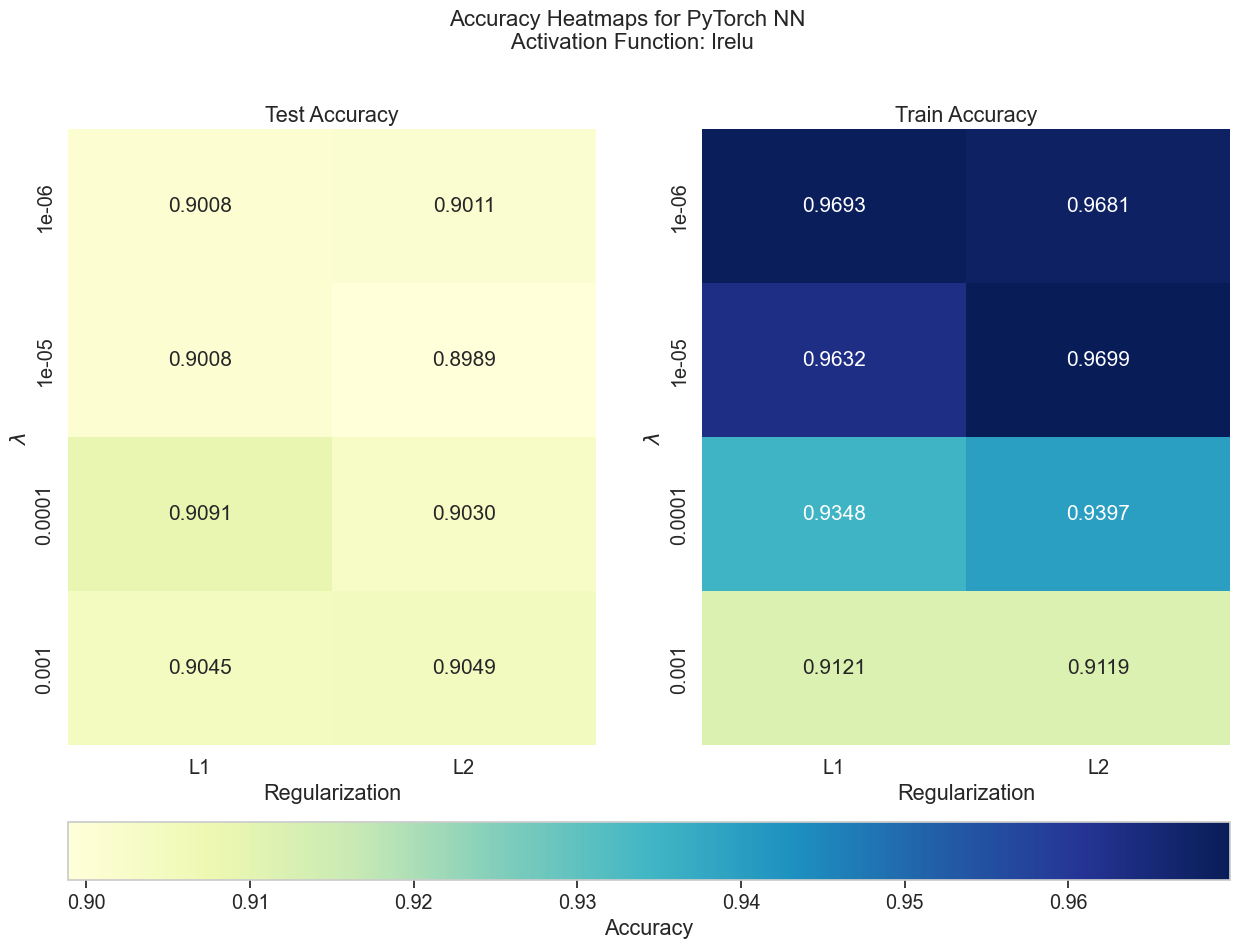

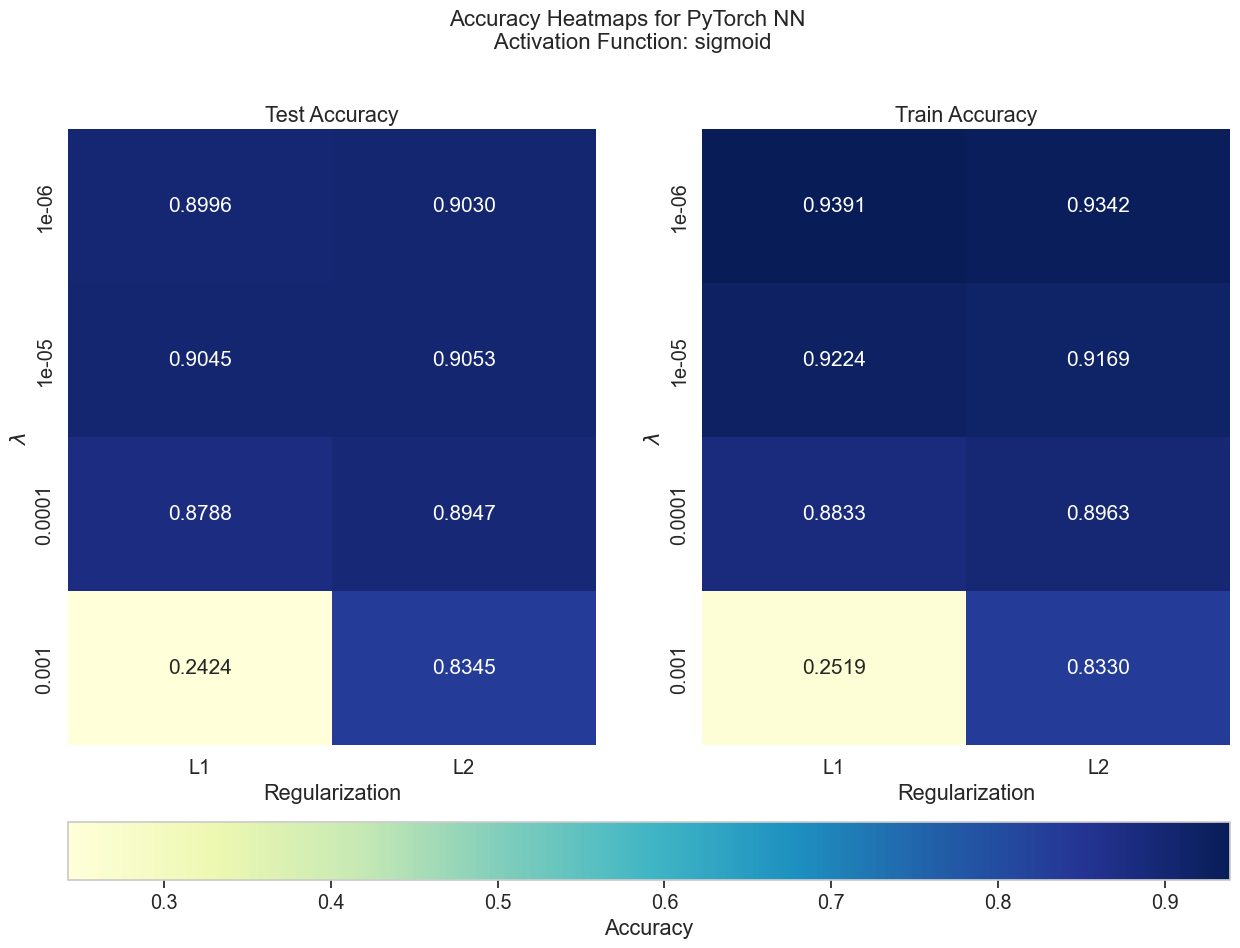

In [37]:
plt.rcParams.update({"font.size": 15})

for activation in activations:

    fig, ax = plt.subplots(1, 2, figsize=(15, 10))

    fig.suptitle(f'Accuracy Heatmaps for PyTorch NN \n Activation Function: {activation}', y = 1.0, fontsize=16)

    pivot_table_test = results_torch_reg[results_torch_reg['Activation'] == activation].pivot_table(
        index="Lambda", columns="Reg", values="Accuracy_test", aggfunc="mean")
    
    pivot_table_train = results_torch_reg[results_torch_reg['Activation'] == activation].pivot_table(
        index="Lambda", columns="Reg", values="Accuracy_train", aggfunc="mean")

    # Shared vmin/vmax across both heatmaps
    vmin = min(pivot_table_test.min().min(), pivot_table_train.min().min())
    vmax = max(pivot_table_test.max().max(), pivot_table_train.max().max())

    im1 = sns.heatmap(pivot_table_test, annot=True, fmt=".4f", cmap="YlGnBu", ax=ax[0], vmin=vmin, vmax=vmax, cbar=False)
    ax[0].set_title(f'Test Accuracy')
    ax[0].set_xlabel('Regularization')
    ax[0].set_ylabel(r'$\lambda$')

    im2 = sns.heatmap(pivot_table_train, annot=True, fmt=".4f", cmap="YlGnBu", ax=ax[1], vmin=vmin, vmax=vmax, cbar=False)
    ax[1].set_title(f'Train Accuracy')
    ax[1].set_xlabel('Regularization')
    ax[1].set_ylabel(r'$\lambda$')

    cbar = fig.colorbar(im2.get_children()[0], ax=ax, orientation="horizontal", pad=0.1, fraction=0.1)
    cbar.set_label('Accuracy')

    plt.show()
    fig.savefig(f'{figpath}/PytorchNN_Accuracy_Heatmap_Lambda_Reg_{activation}.pdf', dpi=200, bbox_inches='tight')

In [38]:
best_model_torch_reg = results_torch_reg.loc[results_torch_reg.groupby('Activation')['Accuracy_test'].idxmax()]

# Summary of results of our PyTorch NN and our own built FFNN:

The first set of experiments were ran with batch size $32$, $\eta = 0.001$ and $50$ epochs. This gave the following results, in terms of best test accuracy for different combinations of hidden layers and nodes:

In [46]:
print("Best FFNN model per activation function (architecture):")
best_model_ffnn_arch

Best FFNN model per activation function (architecture):


,Activation,Hidden Layers,Nodes,Accuracy_train,Accuracy_test
24,lrelu,3,16,0.865246,0.862879
8,relu,3,16,0.865152,0.863258
43,sigmoid,3,128,0.877462,0.877652


In [47]:
print("Best FFNN model per activation function (learning rate and epochs):")
best_model_ffnn_lrs

Best FFNN model per activation function (learning rate and epochs):


,Activation,Learning rate,Epochs,Accuracy_train,Accuracy_test
49,lrelu,0.20,500,0.903314,0.895833
18,relu,0.10,200,0.905398,0.898106
64,sigmoid,0.01,500,0.939583,0.906061


In [48]:
print("Best FFNN model per activation function (regularization):")
best_model_ffnn_reg

Best FFNN model per activation function (regularization):


,Activation,Reg,Lambda,Accuracy_train,Accuracy_test
8,lrelu,L1,0.000001,0.905114,0.896591
7,relu,L2,0.001000,0.899905,0.895076
16,sigmoid,L1,0.000001,0.939583,0.906061


In [39]:
print("Best PyTorch model per activation function (architecture):")
best_torch_model_arch

Best PyTorch model per activation function (architecture):


,Activation,Hidden Layers,Nodes,Accuracy_train,Accuracy_test
22,lrelu,2,64,0.927652,0.910985
11,relu,3,128,0.965720,0.912121
39,sigmoid,2,128,0.901610,0.898864


In [41]:
print("Best PyTorch model per activation function (learning rate and epochs):")
best_model_torch_lrs

Best PyTorch model per activation function (learning rate and epochs):


,Activation,Learning Rate,Epochs,Accuracy_train,Accuracy_test
33,lrelu,0.0010,200,0.977557,0.911364
3,relu,0.0001,200,0.939962,0.908333
61,sigmoid,0.0100,50,0.940341,0.909848


In [43]:
print("Best PyTorch model per activation function (regularization):")
best_model_torch_reg

Best PyTorch model per activation function (regularization):


,Activation,Reg,Lambda,Accuracy_train,Accuracy_test
10,lrelu,L1,0.00010,0.934848,0.909091
6,relu,L2,0.00010,0.931534,0.908712
21,sigmoid,L2,0.00001,0.916856,0.905303


## Confusion matrix and ROC curve
To compare and assess the differences between FFNN and PyTorch NN we use the overall best models of both and see how their confusion matrix and ROC curve are.

**Best FFNN model**
* sigmoid: 3 hidden layers, 128 nodes per layer, learning rate 0.01, 500 epochs, no improvement with regularization. Best test accuracy: 0.906061.
* ReLU: 3 hidden layers, 16 nodes per layer, learning rate 0.1, 200 epochs, no improvement with regularization. Best test accuracy: 0.898106.
* LReLU: 3 hidden layers, 16 nodes per layer, learning rate 0.2, 500 epochs, improvement with L1 regularization and lambda 0.000001. Best test accuracy: 0.896591.

*FFNN winner: sigmoid*!

**Best PyTorch model**
* sigmoid: 2 hidden layers, 128 nodes per layer, learning rate 0.01, 50 epochs, no improvement with regularization. Best test accuracy: 0.909848.
* ReLU: 3 hidden layers, 128 nodes per layer, learning rate 0.0001, 200 epochs, improvement with L2 regularization and lambda 0.0001. Best test accuracy: 0.908712.
* LReLU: 2 hidden layers, 64 nodes per layer, learning rate 0.001, 200 epochs, no improvement with regularization. Best test accuracy: 0.911364

*PyTorch winner: LReLU*!

In [49]:
# The best FFNN model overall
activation_name = 'sigmoid'
activation = sigmoid
nodes = 128
hidden = 3
learning_rate = 0.01
epochs = 500

activation_funcs = [activation] * hidden + [softmax]
activation_ders  = [derivate(activation)] * hidden + [derivate(softmax)]

# Make a model for a given set of hyperparameters
best_FFNN = NeuralNetwork(
network_input_size=X_train.shape[1],
layer_output_sizes=[nodes] * hidden + [4],
activation_funcs=activation_funcs,
activation_ders=activation_ders,
cost_fun=cross_entropy,
cost_der=cross_entropy_der)

# Train network with stochastic gradient descent and Adam optimizer
best_FFNN.train_SGD(X_train, y_train, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size, optimizer='adam')

# Make predictions
y_pred_test_ffnn = best_FFNN._feed_forward(X_test)
y_pred_train_ffnn = best_FFNN._feed_forward(X_train)

# Compute accuracy
accuracy_train_ffnn = evaluate_ffnn_classification(y_pred_train_ffnn, y_train)
accuracy_test_ffnn  = evaluate_ffnn_classification(y_pred_test_ffnn, y_test)

In [52]:
# The best PyTorch model overall
activation = 'lrelu'

num_hidden_layers = 2
num_of_nodes = 64
lr = 0.001
epochs = 200

# Make a model for a given set of hyperparameters
best_pytorch = WeatherNN(input_dim=input_dim, hidden_dim=num_of_nodes, num_hidden_layers=num_hidden_layers, output_dim=num_classes, activation=activation)

# Train the model
training_model = best_pytorch.train_model(train_loader, lr, epochs)

# Predict and evaluate
predictions_train_pytorch = best_pytorch.predict(train_loader)
predictions_test_pytorch = best_pytorch.predict(test_loader)

# Evalute accuracy of model
accuracy_train_pytorch = best_pytorch.evaluate(train_loader)
accuracy_test_pytorch  = best_pytorch.evaluate(test_loader)

AttributeError: 'WeatherNN' object has no attribute 'predict'

In [45]:
# KOPIERT INN FRA UKESOPPGAVE

# Confusion matrix
y_pred = logreg.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

# ROC curve
y_probas = logreg.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()

from sklearn.preprocessing import label_binarize
def multiclass_cumulative_gain(y_test, y_probas):
    classes = np.unique(y_test)

    y_true_bins = label_binarize(y_test, classes=classes)

    for i, cl in enumerate(classes):
        probability = y_probas[:, i]
        # Want to sort the probabilities in descending order
        sorted_indices = np.argsort(probability)[::-1]
        y_true_sorted = y_true_bins[sorted_indices, i]
        
        # Sum of cumulative true positives
        cum_sum_true = np.cumsum(y_true_sorted)
        # The cumulative gain
        cum_gain = cum_sum_true / np.sum(y_true_sorted)
        # Percentage of samples considered
        perc_population = np.arange(1, len(y_test) + 1) / len(y_test)
    
        plt.plot(perc_population, cum_gain, label=f"Class {cl}")
    
    # Random baseline
    plt.plot([0,1], [0,1], '--', color='gray', label="Random")
    
    plt.xlabel("Proportion of Sample")
    plt.ylabel("Cumulative Gain")
    plt.title("Multiclass Cumulative Gain Curves")
    plt.legend()
    plt.grid(True)
    plt.show()

NameError: name 'logreg' is not defined